<a href="https://colab.research.google.com/github/Malik-Raheel/Trading-Strategies/blob/main/Viratt_Alpha_Agents_Backtested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing Virat AGents

In [2]:
pip install ccxt pandas numpy ta scikit-learn matplotlib seaborn requests


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 14.9 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=25da3e12be5317fd15b5aff96d577f799e62e8318262d000a23b947536314a85
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.11
    Uninstalling aiohttp-3.11.11:
      Successfully uninstalled aiohttp-3.11.11


In [3]:
import ccxt
import pandas as pd
import numpy as np
import time

def fetch_data(exchange, symbol, timeframe='1h', limit=100):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

def calculate_indicators(df):
    # Calculate OBV
    df['obv'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

    # Calculate ATR
    df['tr'] = np.maximum(df['high'] - df['low'],
                          np.maximum(abs(df['high'] - df['close'].shift()),
                                     abs(df['low'] - df['close'].shift())))
    df['atr'] = df['tr'].rolling(window=14).mean()

    # Calculate ADX
    df['plus_dm'] = np.where((df['high'] - df['high'].shift()) > (df['low'].shift() - df['low']),
                             np.maximum(df['high'] - df['high'].shift(), 0), 0)
    df['minus_dm'] = np.where((df['low'].shift() - df['low']) > (df['high'] - df['high'].shift()),
                              np.maximum(df['low'].shift() - df['low'], 0), 0)
    df['tr14'] = df['tr'].rolling(window=14).sum()
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window=14).sum() / df['tr14'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window=14).sum() / df['tr14'])
    df['dx'] = 100 * abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di'])
    df['adx'] = df['dx'].rolling(window=14).mean()

    # Calculate Z-Score
    df['mean'] = df['close'].rolling(window=20).mean()
    df['std'] = df['close'].rolling(window=20).std()
    df['z_score'] = (df['close'] - df['mean']) / df['std']

    return df

def analyze_asset(symbol, df):
    last_row = df.iloc[-1]

    # Interpret ADX
    adx = last_row['adx']
    if adx < 20:
        adx_interpretation = "Weak trend"
    elif 20 <= adx < 40:
        adx_interpretation = "Moderate trend"
    else:
        adx_interpretation = "Strong trend"

    # Interpret Z-Score
    z_score = last_row['z_score']
    if z_score < -1:
        z_score_interpretation = "Oversold (price significantly below mean)"
    elif z_score > 1:
        z_score_interpretation = "Overbought (price significantly above mean)"
    else:
        z_score_interpretation = "Neutral (price near mean)"

    return {
        "symbol": symbol,
        "obv": last_row['obv'],
        "atr": last_row['atr'],
        "adx": adx,
        "adx_interpretation": adx_interpretation,
        "z_score": z_score,
        "z_score_interpretation": z_score_interpretation
    }

def main():
    exchange = ccxt.kucoin()
    assets = ['BTC/USDT', 'NEAR/USDT', 'HNT/USDT', 'ETH/USDT', 'XAVA/USDT',
              'STG/USDT', 'SOL/USDT', 'ADA/USDT', 'XRP/USDT', 'LINK/USDT']

    results = []

    for asset in assets:
        try:
            df = fetch_data(exchange, asset)
            df = calculate_indicators(df)
            analysis = analyze_asset(asset, df)
            results.append(analysis)
        except Exception as e:
            print(f"Error processing {asset}: {e}")

    # Display Results
    print("\nAsset Analysis Results:")
    for result in results:
        print(f"\nSymbol: {result['symbol']}\n"
              f"OBV: {result['obv']:.2f}\n"
              f"ATR: {result['atr']:.4f} (Volatility Measure)\n"
              f"ADX: {result['adx']:.2f} ({result['adx_interpretation']})\n"
              f"Z-Score: {result['z_score']:.2f} ({result['z_score_interpretation']})")

if __name__ == "__main__":
    main()



Asset Analysis Results:

Symbol: BTC/USDT
OBV: -757.22
ATR: 497.9714 (Volatility Measure)
ADX: 21.03 (Moderate trend)
Z-Score: -1.05 (Oversold (price significantly below mean))

Symbol: NEAR/USDT
OBV: -128649.08
ATR: 0.0610 (Volatility Measure)
ADX: 43.88 (Strong trend)
Z-Score: -1.13 (Oversold (price significantly below mean))

Symbol: HNT/USDT
OBV: 61251.16
ATR: 0.0624 (Volatility Measure)
ADX: 69.70 (Strong trend)
Z-Score: -1.05 (Oversold (price significantly below mean))

Symbol: ETH/USDT
OBV: 15834.33
ATR: 23.5521 (Volatility Measure)
ADX: 56.04 (Strong trend)
Z-Score: -0.92 (Neutral (price near mean))

Symbol: XAVA/USDT
OBV: 47894.30
ATR: 0.0064 (Volatility Measure)
ADX: 35.10 (Moderate trend)
Z-Score: -0.78 (Neutral (price near mean))

Symbol: STG/USDT
OBV: 311586.80
ATR: 0.0036 (Volatility Measure)
ADX: 15.40 (Weak trend)
Z-Score: -1.05 (Oversold (price significantly below mean))

Symbol: SOL/USDT
OBV: 190886.04
ATR: 3.2864 (Volatility Measure)
ADX: 65.13 (Strong trend)
Z-Scor

# **Average Directional Index (ADX)**
Purpose: Measures trend strength.
Usage:
A high ADX (e.g., above 25) suggests a strong trend (either up or down).
A low ADX suggests a weak or sideways market.

# **Z-Score**
Purpose: Measures how far the current price deviates from its rolling mean (mean reversion indicator).
Usage:
A low Z-Score (e.g., below -1) indicates the price is significantly below its mean, potentially offering a bullish opportunity for mean reversion.

Backtesting

Backtesting BTC/USDT...
Backtesting ETH/USDT...
Backtesting XRP/USDT...
Backtesting ADA/USDT...

--- BTC/USDT Backtesting Results ---
Total Trades: 196
Profitable Trades: 51
Win Ratio: 26.02%
Cumulative Profit: $-25.69
Ending Balance: $-25.69

Trade: BUY, Entry: 95701.40, Exit: 95669.7, Profit: -0.33
Trade: BUY, Entry: 95703.90, Exit: 95453.5, Profit: -2.62
Trade: BUY, Entry: 96047.70, Exit: 95822.3, Profit: -2.35
Trade: BUY, Entry: 96096.60, Exit: 95560.8, Profit: -5.58
Trade: BUY, Entry: 95807.80, Exit: 95785.8, Profit: -0.23
Trade: BUY, Entry: 95789.40, Exit: 96291.3, Profit: 5.24
Trade: BUY, Entry: 96590.40, Exit: 95106.4, Profit: -15.36
Trade: BUY, Entry: 95725.90, Exit: 96610.3, Profit: 9.24
Trade: BUY, Entry: 96951.00, Exit: 96686.6, Profit: -2.73
Trade: BUY, Entry: 94291.20, Exit: 94576.9, Profit: 3.03
Trade: BUY, Entry: 94378.00, Exit: 94336.5, Profit: -0.44
Trade: BUY, Entry: 94587.00, Exit: 94518.5, Profit: -0.72
Trade: BUY, Entry: 94624.30, Exit: 94466.5, Profit: -1.67
Trad

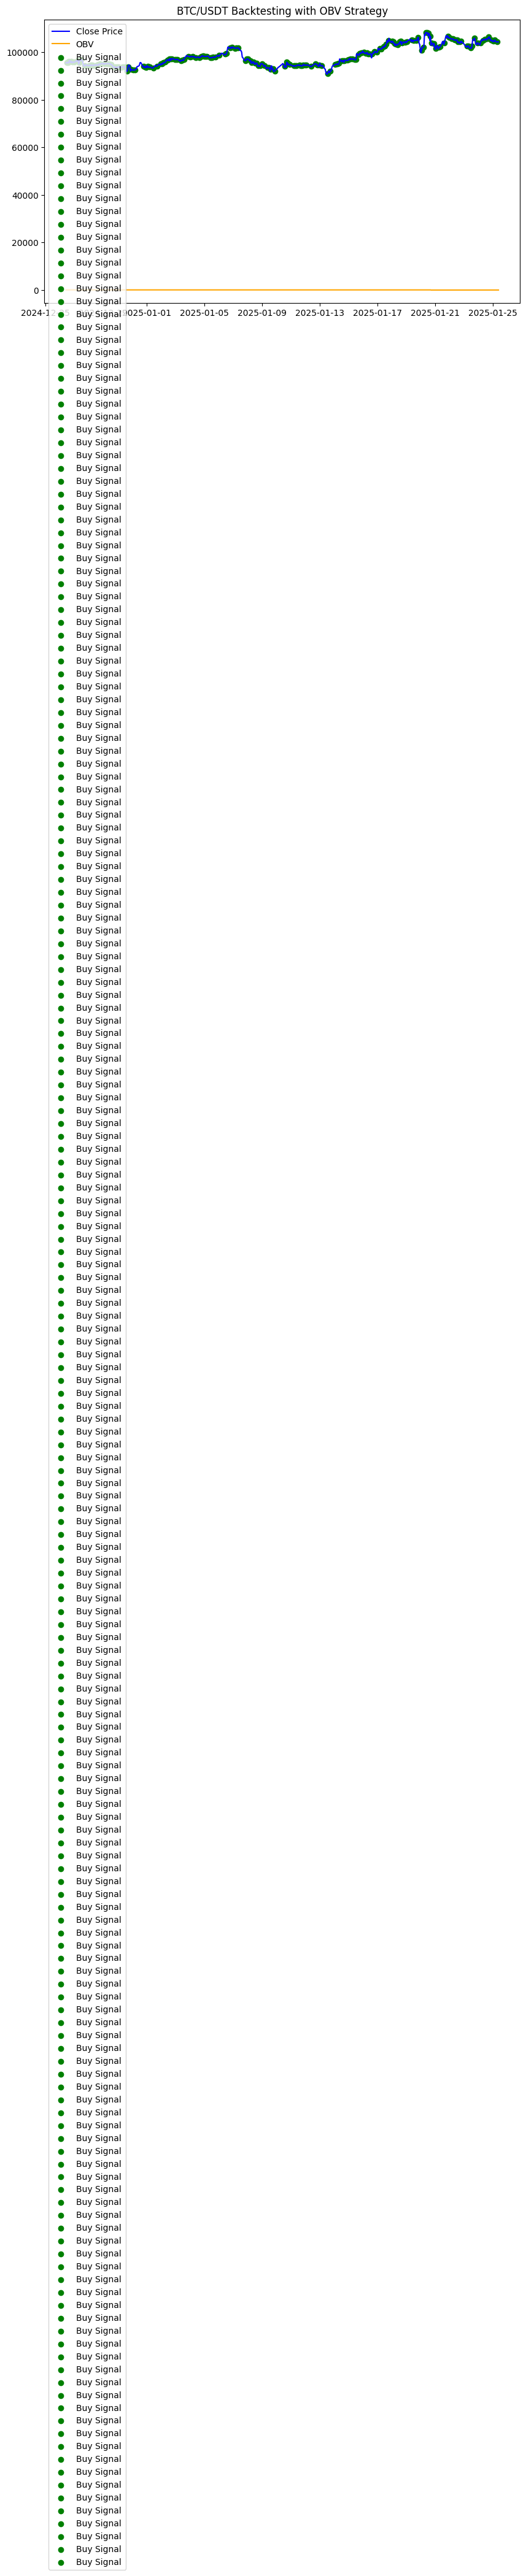

In [5]:
# Install necessary libraries
!pip install ccxt pandas matplotlib

import ccxt
import pandas as pd
import matplotlib.pyplot as plt

# Initialize CCXT for KuCoin
exchange = ccxt.kucoin()

# Function to fetch historical data
def fetch_historical_data(symbol, timeframe='1h', limit=720):
    """
    Fetch historical OHLCV data for a given symbol and timeframe.
    Args:
        symbol (str): The trading pair (e.g., BTC/USDT).
        timeframe (str): Timeframe for the candles (e.g., '1h').
        limit (int): Number of candles to fetch.
    Returns:
        pd.DataFrame: Historical data with datetime index.
    """
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Strategy logic (simple OBV-based example)
def apply_strategy(df, starting_balance=1000):
    """
    Apply a simple OBV-based strategy to the data and evaluate performance.
    Args:
        df (pd.DataFrame): Historical data with OHLCV.
        starting_balance (float): Initial balance for each trade.
    Returns:
        dict: Strategy results including trades, profit/loss, and metrics.
    """
    df['obv'] = (df['volume'] * ((df['close'] - df['open']) / df['open'])).cumsum()
    df['obv_signal'] = df['obv'].diff().apply(lambda x: 'BUY' if x > 0 else 'SELL')

    trades = []
    balance = 0
    position = None  # Holds current trade position
    entry_price = 0

    for i in range(1, len(df)):
        if df['obv_signal'].iloc[i] == 'BUY' and position is None:
            position = 'BUY'
            entry_price = df['close'].iloc[i]
            trades.append({
                'type': 'BUY',
                'price': entry_price,
                'timestamp': df.index[i],
                'amount': starting_balance / entry_price
            })

        elif df['obv_signal'].iloc[i] == 'SELL' and position == 'BUY':
            exit_price = df['close'].iloc[i]
            profit = (exit_price - entry_price) * trades[-1]['amount']
            balance += profit
            trades[-1].update({
                'exit_price': exit_price,
                'exit_timestamp': df.index[i],
                'profit': profit
            })
            position = None  # Close position

    # Evaluate metrics
    total_trades = len(trades)
    profitable_trades = sum(1 for t in trades if 'profit' in t and t['profit'] > 0)
    win_ratio = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
    cumulative_profit = sum(t['profit'] for t in trades if 'profit' in t)

    return {
        'trades': trades,
        'total_trades': total_trades,
        'profitable_trades': profitable_trades,
        'win_ratio': win_ratio,
        'cumulative_profit': cumulative_profit,
        'balance': balance
    }

# Backtest assets
assets = ['BTC/USDT', 'ETH/USDT', 'XRP/USDT', 'ADA/USDT']
results = {}

for asset in assets:
    print(f"Backtesting {asset}...")
    historical_data = fetch_historical_data(asset, timeframe='1h', limit=720)
    strategy_results = apply_strategy(historical_data, starting_balance=1000)
    results[asset] = strategy_results

# Display Results
for asset, result in results.items():
    print(f"\n--- {asset} Backtesting Results ---")
    print(f"Total Trades: {result['total_trades']}")
    print(f"Profitable Trades: {result['profitable_trades']}")
    print(f"Win Ratio: {result['win_ratio']:.2f}%")
    print(f"Cumulative Profit: ${result['cumulative_profit']:.2f}")
    print(f"Ending Balance: ${result['balance']:.2f}\n")

    # Display trade details
    for trade in result['trades']:
        print(f"Trade: {trade['type']}, Entry: {trade['price']:.2f}, "
              f"Exit: {trade.get('exit_price', 'N/A')}, "
              f"Profit: {trade.get('profit', 'N/A'):.2f}")

# Optional: Plot for one asset
example_asset = 'BTC/USDT'
if example_asset in results:
    example_trades = results[example_asset]['trades']
    df = fetch_historical_data(example_asset, timeframe='1h', limit=720)
    df['obv'] = (df['volume'] * ((df['close'] - df['open']) / df['open'])).cumsum()

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['close'], label='Close Price', color='blue')
    plt.plot(df.index, df['obv'], label='OBV', color='orange')

    # Mark trades
    for trade in example_trades:
        if trade['type'] == 'BUY':
            plt.scatter(trade['timestamp'], trade['price'], color='green', label='Buy Signal')
        elif 'exit_price' in trade:
            plt.scatter(trade['exit_timestamp'], trade['exit_price'], color='red', label='Sell Signal')

    plt.legend()
    plt.title(f"{example_asset} Backtesting with OBV Strategy")
    plt.show()
